<a href="https://colab.research.google.com/github/maakhhh/dl_learning/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

In [ ]:
df = pd.read_csv('Titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


На данном этапе можно убрать следующие данные:


*   PassengerID - просто ID пассажира, не может влиять на выживаемость
*   Name - уникальное имя пассажира, также не может влиять на его выживаемость
*   Embarked - город посадки пассажира, также не может влиять на выживаемость, особенно на больших данных
*   Ticket - номер билета пассажира, скорее всего не имеет влияения на выживаемость



In [ ]:
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Embarked', axis=1)
df = df.drop('Ticket', axis=1)

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687


Cabin имеет очень много нулов, корретно дозаполнить эту колонку мы не можем, поэтому также можем ее удалить для более точной оценки выживаемости.

In [ ]:
df = df.drop('Cabin', axis=1)

Далее у нас остается одна колонка не int, переводим ее в int

In [ ]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})

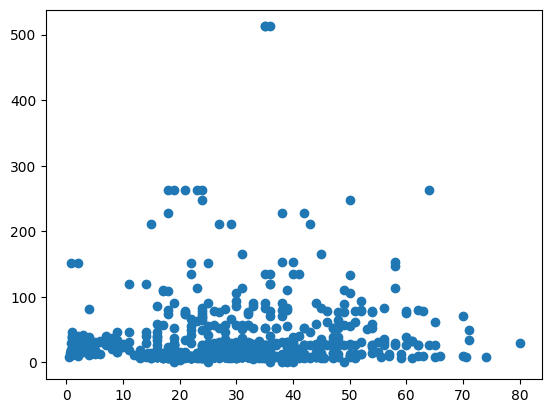

In [ ]:
plt.scatter(df['Age'], df['Fare'])

На графике зависимости цены билета от возраста видим, что есть группа среднего возраста с повышенной стоимостью билета => на основе этого можем предположить, что цена билета зависит от возраста (и наоборот)

<Axes: xlabel='Sex', ylabel='Age'>

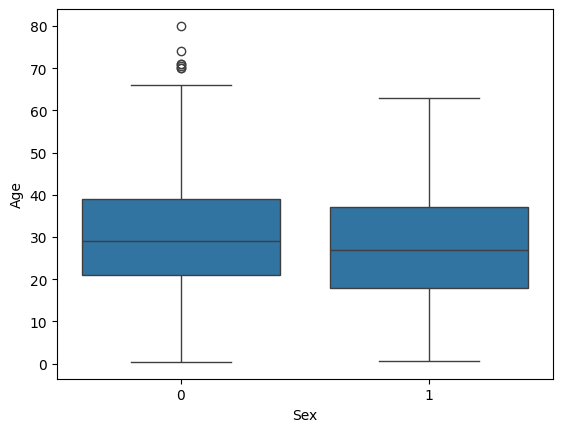

In [ ]:
sns.boxplot(x='Sex', y='Age', data=df)

На так называемом ящике с усами видно, что мужчины в целом старше и имеют больше выбросов по возрасте, также ниже рассмотрим процент выживаемости в зависимости от возраста

<BarContainer object of 71 artists>

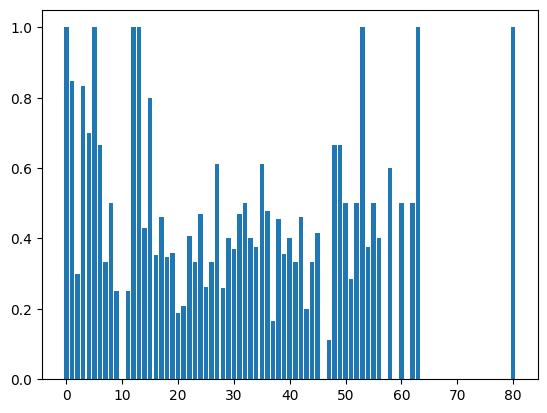

In [ ]:
ages_round = df['Age'].round()
survival_rates = df.groupby(ages_round)['Survived'].mean()
plt.bar(survival_rates.index, survival_rates.values)

На графике также видно зависимость выживаемости от возраста, в группе среднего возраста выживаемость значительно ниже, чем в группах от 0 до 15 и от 55 до 80 лет.

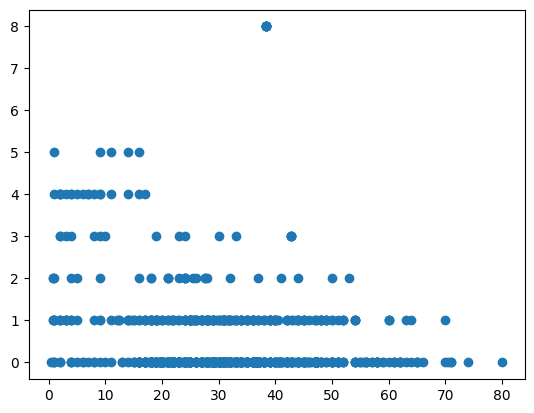

In [ ]:
plt.scatter(df['Age'], df['SibSp'])

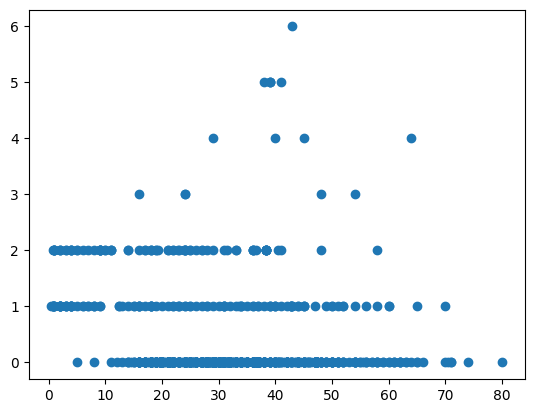

In [ ]:
plt.scatter(df['Age'], df['Parch'])

В целом на двух графиках выше мы можем увидеть зависимость Age от Sibsp и Parch, однако эти метрики являются достаточно сложными (количество братьев, сестер и супругов/ количество родителей или детей), поэтому я бы не стал их учитывать для предугадывания возраста пассажиров.

На основе графиков мы можем создать модель К-ближайших соседей для того, чтобы достроить возраст оставшихся пассажиров, в качестве параметров будем брать выживаемость, стоимость билета и пол.

In [ ]:
predictors = ['Sex', 'Survived', 'Fare']
df_tr = df[~df['Age'].isnull()]
md = KNeighborsRegressor(n_neighbors=5)
md.fit(df_tr[predictors], df_tr['Age'])
df_tst = df[df['Age'].isnull()]
age = md.predict(df_tst[predictors])
df.loc[df['Age'].isnull(), 'Age'] = age

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0


Теперь у нас есть все данные в таблице, можем строить модели

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
def get_metrix_of_model(model, epochs, name, X_train, y_train, X_test, y_test):
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  model.fit(
      X_train, y_train,
      epochs=epochs,
      validation_data=(X_test, y_test)
  )
  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
  y_pred = (model.predict(X_test) > 0.5).astype(int)
  f1 = f1_score(y_test, y_pred)
  print(f'Модель {name}:')
  print(f'Точность: {accuracy}')
  print(f'F1-мера: {f1}')

In [ ]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=52)


In [ ]:
md1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1, 10, "Простая полносвязная сеть", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4440 - loss: 2.2411 - val_accuracy: 0.6716 - val_loss: 0.9074
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6826 - loss: 0.7194 - val_accuracy: 0.6716 - val_loss: 0.6184
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7042 - loss: 0.5617 - val_accuracy: 0.6940 - val_loss: 0.6181
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7308 - loss: 0.5673 - val_accuracy: 0.6716 - val_loss: 0.6381
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7125 - loss: 0.5801 - val_accuracy: 0.6716 - val_loss: 0.6302
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.5587 - val_accuracy: 0.6866 - val_loss: 0.6291
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7515 - loss: 0.5483 - val_accuracy: 0.6791 - val_loss: 0.6467
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7372 - loss: 0.5411 - val_accuracy: 0.7015 - val_loss: 0.5535
Ep

In [ ]:
md2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md2, 10, "Сеть с дропаутом", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6096 - loss: 1.7136 - val_accuracy: 0.6940 - val_loss: 0.7540
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6391 - loss: 1.1277 - val_accuracy: 0.6343 - val_loss: 0.7386
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6585 - loss: 0.8316 - val_accuracy: 0.6418 - val_loss: 0.8117
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6643 - loss: 0.8358 - val_accuracy: 0.7164 - val_loss: 0.5926
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6508 - loss: 0.8330 - val_accuracy: 0.6866 - val_loss: 0.7935
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6217 - loss: 0.8181 - val_accuracy: 0.6642 - val_loss: 0.6823
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6512 - loss: 0.8178 - val_accuracy: 0.6418 - val_loss: 0.7069
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6905 - loss: 0.6371 - val_accuracy: 0.6791 - val_loss: 0.6458
Ep

In [ ]:
md3 = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
get_metrix_of_model(md3, 10, "Сеть с рекуррентным слоем", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6217 - loss: 0.6625 - val_accuracy: 0.6642 - val_loss: 0.6255
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6723 - loss: 0.6111 - val_accuracy: 0.6269 - val_loss: 0.6358
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6791 - loss: 0.5916 - val_accuracy: 0.6493 - val_loss: 0.6213
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6731 - loss: 0.6037 - val_accuracy: 0.6642 - val_loss: 0.6142
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6688 - loss: 0.6031 - val_accuracy: 0.6642 - val_loss: 0.6234
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6681 - loss: 0.6035 - val_accuracy: 0.6642 - val_loss: 0.6085
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6477 - loss: 0.5946 - val_accuracy: 0.6642 - val_loss: 0.6120
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6601 - loss: 0.6040 - val_accuracy: 0.6642 - val_loss: 0.6146
E

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Модель Сеть с рекуррентным слоем:
Точность: 0.6716417670249939
F1-мера: 0.42105263157894735


Лучшая точность у простой полносвязной сети, поэксперементируем с топологией сети:

In [ ]:
md1_1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_1, 10, "128-64-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6412 - loss: 1.4305 - val_accuracy: 0.6642 - val_loss: 0.6290
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6907 - loss: 0.5897 - val_accuracy: 0.6866 - val_loss: 0.6361
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7001 - loss: 0.6343 - val_accuracy: 0.6791 - val_loss: 0.7131
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7064 - loss: 0.6095 - val_accuracy: 0.7015 - val_loss: 0.5784
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7153 - loss: 0.5988 - val_accuracy: 0.7015 - val_loss: 0.5586
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7496 - loss: 0.5071 - val_accuracy: 0.7164 - val_loss: 0.5830
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7636 - loss: 0.5257 - val_accuracy: 0.7313 - val_loss: 0.5331
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7761 - loss: 0.5135 - val_accuracy: 0.7239 - val_loss: 0.5454
Ep

In [ ]:
md1_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2, 10, "64-128-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5653 - loss: 1.0626 - val_accuracy: 0.5672 - val_loss: 0.7495
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6277 - loss: 0.6839 - val_accuracy: 0.6567 - val_loss: 0.7658
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6932 - loss: 0.5911 - val_accuracy: 0.6866 - val_loss: 0.6093
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.6365 - val_accuracy: 0.7164 - val_loss: 0.5800
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7314 - loss: 0.5979 - val_accuracy: 0.6866 - val_loss: 0.6212
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6998 - loss: 0.6027 - val_accuracy: 0.7015 - val_loss: 0.6459
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7160 - loss: 0.5835 - val_accuracy: 0.6493 - val_loss: 0.7873
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7390 - loss: 0.5280 - val_accuracy: 0.7239 - val_loss: 0.6632
Ep

In [ ]:
md1_3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_3, 10, "32-64-32-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6519 - loss: 0.6553 - val_accuracy: 0.6940 - val_loss: 0.6110
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6948 - loss: 0.5866 - val_accuracy: 0.6567 - val_loss: 0.6280
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6958 - loss: 0.5896 - val_accuracy: 0.6194 - val_loss: 0.7561
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6778 - loss: 0.6167 - val_accuracy: 0.6567 - val_loss: 0.6513
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7012 - loss: 0.5793 - val_accuracy: 0.7015 - val_loss: 0.5888
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7020 - loss: 0.5888 - val_accuracy: 0.6716 - val_loss: 0.6074
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7178 - loss: 0.5695 - val_accuracy: 0.6940 - val_loss: 0.5982
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6723 - loss: 0.5873 - val_accuracy: 0.7164 - val_loss: 0.5706
Ep

Лучшие метрики показала модель с топологией 64-128-1, можем также посмотреть на данную модель с разным количеством нейронов:

In [ ]:
md1_2_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_1, 10, "64-256-1", X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6172 - loss: 0.9844 - val_accuracy: 0.6567 - val_loss: 0.6244
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6677 - loss: 0.6247 - val_accuracy: 0.7239 - val_loss: 0.6019
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7256 - loss: 0.5558 - val_accuracy: 0.7090 - val_loss: 0.6044
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7200 - loss: 0.5707 - val_accuracy: 0.6791 - val_loss: 0.6047
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7150 - loss: 0.5720 - val_accuracy: 0.7015 - val_loss: 0.6751
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6884 - loss: 0.5777 - val_accuracy: 0.6716 - val_loss: 0.6669
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7072 - loss: 0.6064 - val_accuracy: 0.6940 - val_loss: 0.6371
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6686 - loss: 0.6595 - val_accuracy: 0.6940 - val_lo

In [ ]:
md1_2_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_2, 10, "128-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5993 - loss: 1.0087 - val_accuracy: 0.6791 - val_loss: 0.6007
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6651 - loss: 0.6241 - val_accuracy: 0.6866 - val_loss: 0.5986
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7095 - loss: 0.5944 - val_accuracy: 0.7015 - val_loss: 0.5691
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7013 - loss: 0.5718 - val_accuracy: 0.7090 - val_loss: 0.5635
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7309 - loss: 0.5333 - val_accuracy: 0.7015 - val_loss: 0.5853
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7314 - loss: 0.6487 - val_accuracy: 0.7239 - val_loss: 0.6827
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7332 - loss: 0.5906 - val_accuracy: 0.7313 - val_loss: 0.6924
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8076 - loss: 0.4696 - val_accuracy: 0.7164 - val_loss: 0.5198
E

In [ ]:
md1_2_3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_3, 10, "128-512-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6152 - loss: 1.1760 - val_accuracy: 0.5224 - val_loss: 0.8068
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6681 - loss: 0.6549 - val_accuracy: 0.6940 - val_loss: 0.6693
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6807 - loss: 0.6149 - val_accuracy: 0.6493 - val_loss: 0.7445
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6954 - loss: 0.6399 - val_accuracy: 0.6418 - val_loss: 0.7873
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7052 - loss: 0.6050 - val_accuracy: 0.6866 - val_loss: 0.6422
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7371 - loss: 0.5714 - val_accuracy: 0.7388 - val_loss: 0.5343
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7546 - loss: 0.4838 - val_accuracy: 0.7164 - val_loss: 0.5305
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7006 - loss: 0.5997 - val_accuracy: 0.6940 - val_loss: 0.6490
Ep

Лучшие метрики показала модель с 128-512-1 нейроном


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

kFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=52)

f1s = []
reports = []
matrixes = []

for train_index, test_index in kFold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        epochs=10,
        verbose=0
    )

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    report = classification_report(y_test, y_pred)
    reports.append(report)
    matrix = confusion_matrix(y_test, y_pred)
    matrixes.append(matrix)

    print(f'Фолд:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')
    print(f'Classification Report:\n{report}')
    print(f'Confusion Matrix:\n{matrix}')

print('\nСредние значения по всем фолдам:')
print(f'Средняя F1-мера: {sum(f1s) / len(f1s)}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Фолд:
Точность: 0.804713785648346
F1-мера: 0.7716535433070866
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       183
           1       0.70      0.86      0.77       114

    accuracy                           0.80       297
   macro avg       0.80      0.82      0.80       297
weighted avg       0.82      0.80      0.81       297

Confusion Matrix:
[[141  42]
 [ 16  98]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Фолд:
Точность: 0.6262626051902771
F1-мера: 0.05128205128205128
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       183
           1       1.00      0.03      0.05       114

    accuracy                           0.63       297
   macro avg       0.81      0.51      0.41       297
weighted avg       0.77      0.63      0.49       297

Confusion Matrix:
[[183   0]
 [111   3]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Фолд:
Точность: 0.6700336933135986
F1-мера: 0.30985915492957744
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.97      0.78       183
           1       0.79      0.19      0.31       114

    accuracy                           0.67       297
   macro avg       0.72      0.58      0.55       297
weighted avg       0.71      0.67      0.60       297

Confusion Matrix:
[[177   6]
 [ 92  22]]

Средние значения по всем фолдам:
Средняя F1-мера: 0.3775982498395718


По фолдам модель дает следующие результаты:


1.   141 погибших предугадано верно, 42 отнесли к неверному классу. 16 выживших угаданы верно, 98 отнесены к неверному классу.
2.   183 погибших предугадано верно, 0 отнесли к неверному классу. 111 выживших угаданы верно, 3 отнесены к неверному классу.
3.  177 погибших предугадано верно, 6 отнесли к неверному классу. 92 выживших угаданы верно, 22 отнесены к неверному классу.

Вывод: был сделан EDA данных, протестировано 9 различных моделей с целью найти самую эффективную, эта модель была протестирована на трех фолдах, на двух из них она показала неплохой результат, однако не лучший. Проблемой я вижу недостаточно точный EDA данных и небольшой размер датасета (в котором присутствует дизбаланс классов).
